In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [87]:
def marker_plot(ds: loompy.LoomConnection, out_file: str, markers: list, lay: str = 'smooth', embedding: str = "TSNE") -> None:
    '''
    Generates a multi-panel plot to inspect UMI and Bin counts.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(np.ceil(nM/5)*6, 8))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## GA score    
        v = ds[lay][ds.ra['Gene'] == m, :][0]
        k = v > 0
        GA = np.log10(v[k] / (ds.ca['passed_filters'][k]*1e-6))
        
        ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
        im = ax.scatter(pos[k,0], pos[k,1], cmap='viridis', c=GA, marker='.', lw=0, s=epsilon)
        
        fig.colorbar(im, ax=ax, orientation='vertical')
        ax.set_title(f'{m}:  {ds.ra.loc[ds.ra.Gene == m]}')
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

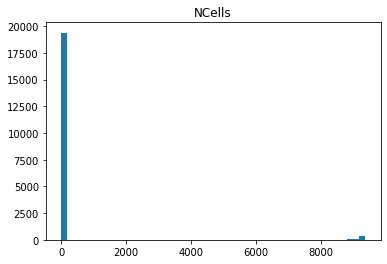

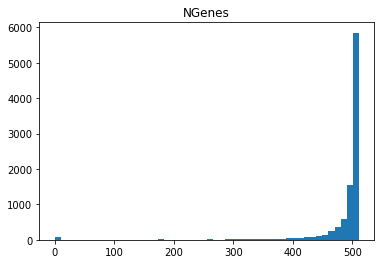

12:38:32 INFO     Total 510 valids


['PAX7', 'FHL1', 'ETV1', 'HMGB3']


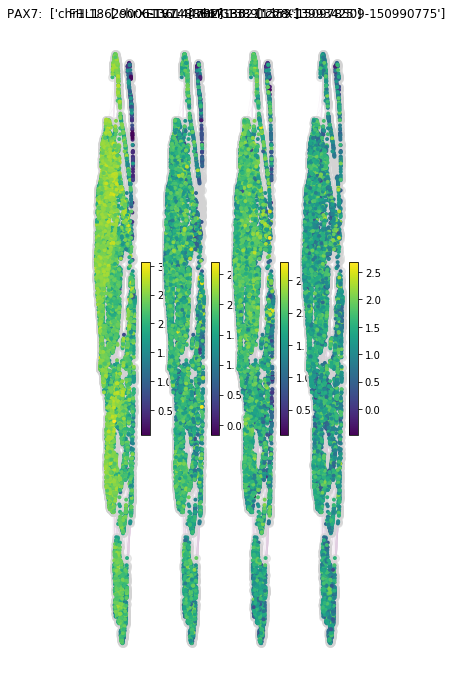

In [88]:
build = '/data/proj/scATAC/chromograph/build_20200216/'
with loompy.connect(os.path.join(build, 'Midbrain_GA.loom')) as ds:
    lay = 'smooth'
    NCells = ds[lay].map([np.count_nonzero], axis=0)[0]
    NGenes = ds[lay].map([np.count_nonzero], axis=1)[0]
    plt.hist(NCells, bins = 50)
    plt.title('NCells')
    plt.show()
    plt.hist(NGenes, bins = 50)
    plt.title('NGenes')
    plt.show()
    
    valids = ds.ra['Gene'][NCells > 100]
    logging.info(f'Total {len(valids)} valids')
    
    markers = ['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 
           'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 
           'OLIG2', 'ETV5', 'RX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 
           'SALL2','HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2',
           'NEUROD6', 'ZNF33A', 'PHTF1']
    plot_markers = [x for x in markers if x in valids]
    print(plot_markers)
    marker_plot(ds, os.path.join(build, 'exported/marker_plot.png'), markers = plot_markers, lay= lay, embedding = 'UMAP')

In [93]:
build = '/data/proj/scATAC/chromograph/build_20200216/'
with loompy.connect(os.path.join(build, 'Midbrain.loom')) as ds:
    print(ds.ca['SampleID'])
    print(ds.ca.keys())

['10X232_3' '10X232_3' '10X232_3' ... '10X232_4' '10X232_4' '10X232_4']
['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'Editat', 'Editby', 'Finalconc', 'Id', 'Idxset', 'Inputmrna', 'Label', 'Method', 'Molarity', 'NBins', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'SampleID', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcod

In [75]:
# markers = ['TNC', 'TOP2A', 'EOMES', 'CLDN5', 'CD248', 'NTN1', 
#            'HMGB2', 'NEUROD1', 'NKX6-2', 'FOXD2', 'MEIS2', 'GATA3', 
#            'POU4F1', 'ALDH1A1', 'RHBDD1', 'LRRC10B', 'PRDM13', 'CXCR4', 
#            'MSX1', 'DCX', 'RFX4']

markers = ['PTF1A', 'PRDM13', 'PAX3', 'PAX7', 'ZSCAN1', 'ENO1', 'GTF2F2', 'TOX', 'JADE1', 'ZEB2', 'TCF3', 
           'ETV4', 'LHX3', 'MSX1', 'GABPB2', 'SAMD13', 
           'OLIG2', 'ETV5', 'RX4', 'DBX2', 'FHL1', 'HEY1', 'ETV1', 'GLIS3', 'ID4', 'KLF15', 'NACC2', 'MKX', 
           'SALL2','HMGA2', 'NHLH1', 'NEUROD4', 'NEUROD1', 'NEUROG2', 'DMBX1', 'HMGB1', 'HMGB3', 'NR2F6', 'MBD4', 'GTF2H2',
           'NEUROD6', 'ZNF33A', 'PHTF1']

# markers = ['MEOX1', 'PAX7', 'ETV1', 'FHL1', 'TACC3', 'VIM', 'NANOG', 'POU5F1B']
valids = ds.ra['Gene'][NCells > 100]
[print(x) for x in markers if x in valids]

TypeError: 'NoneType' object is not subscriptable

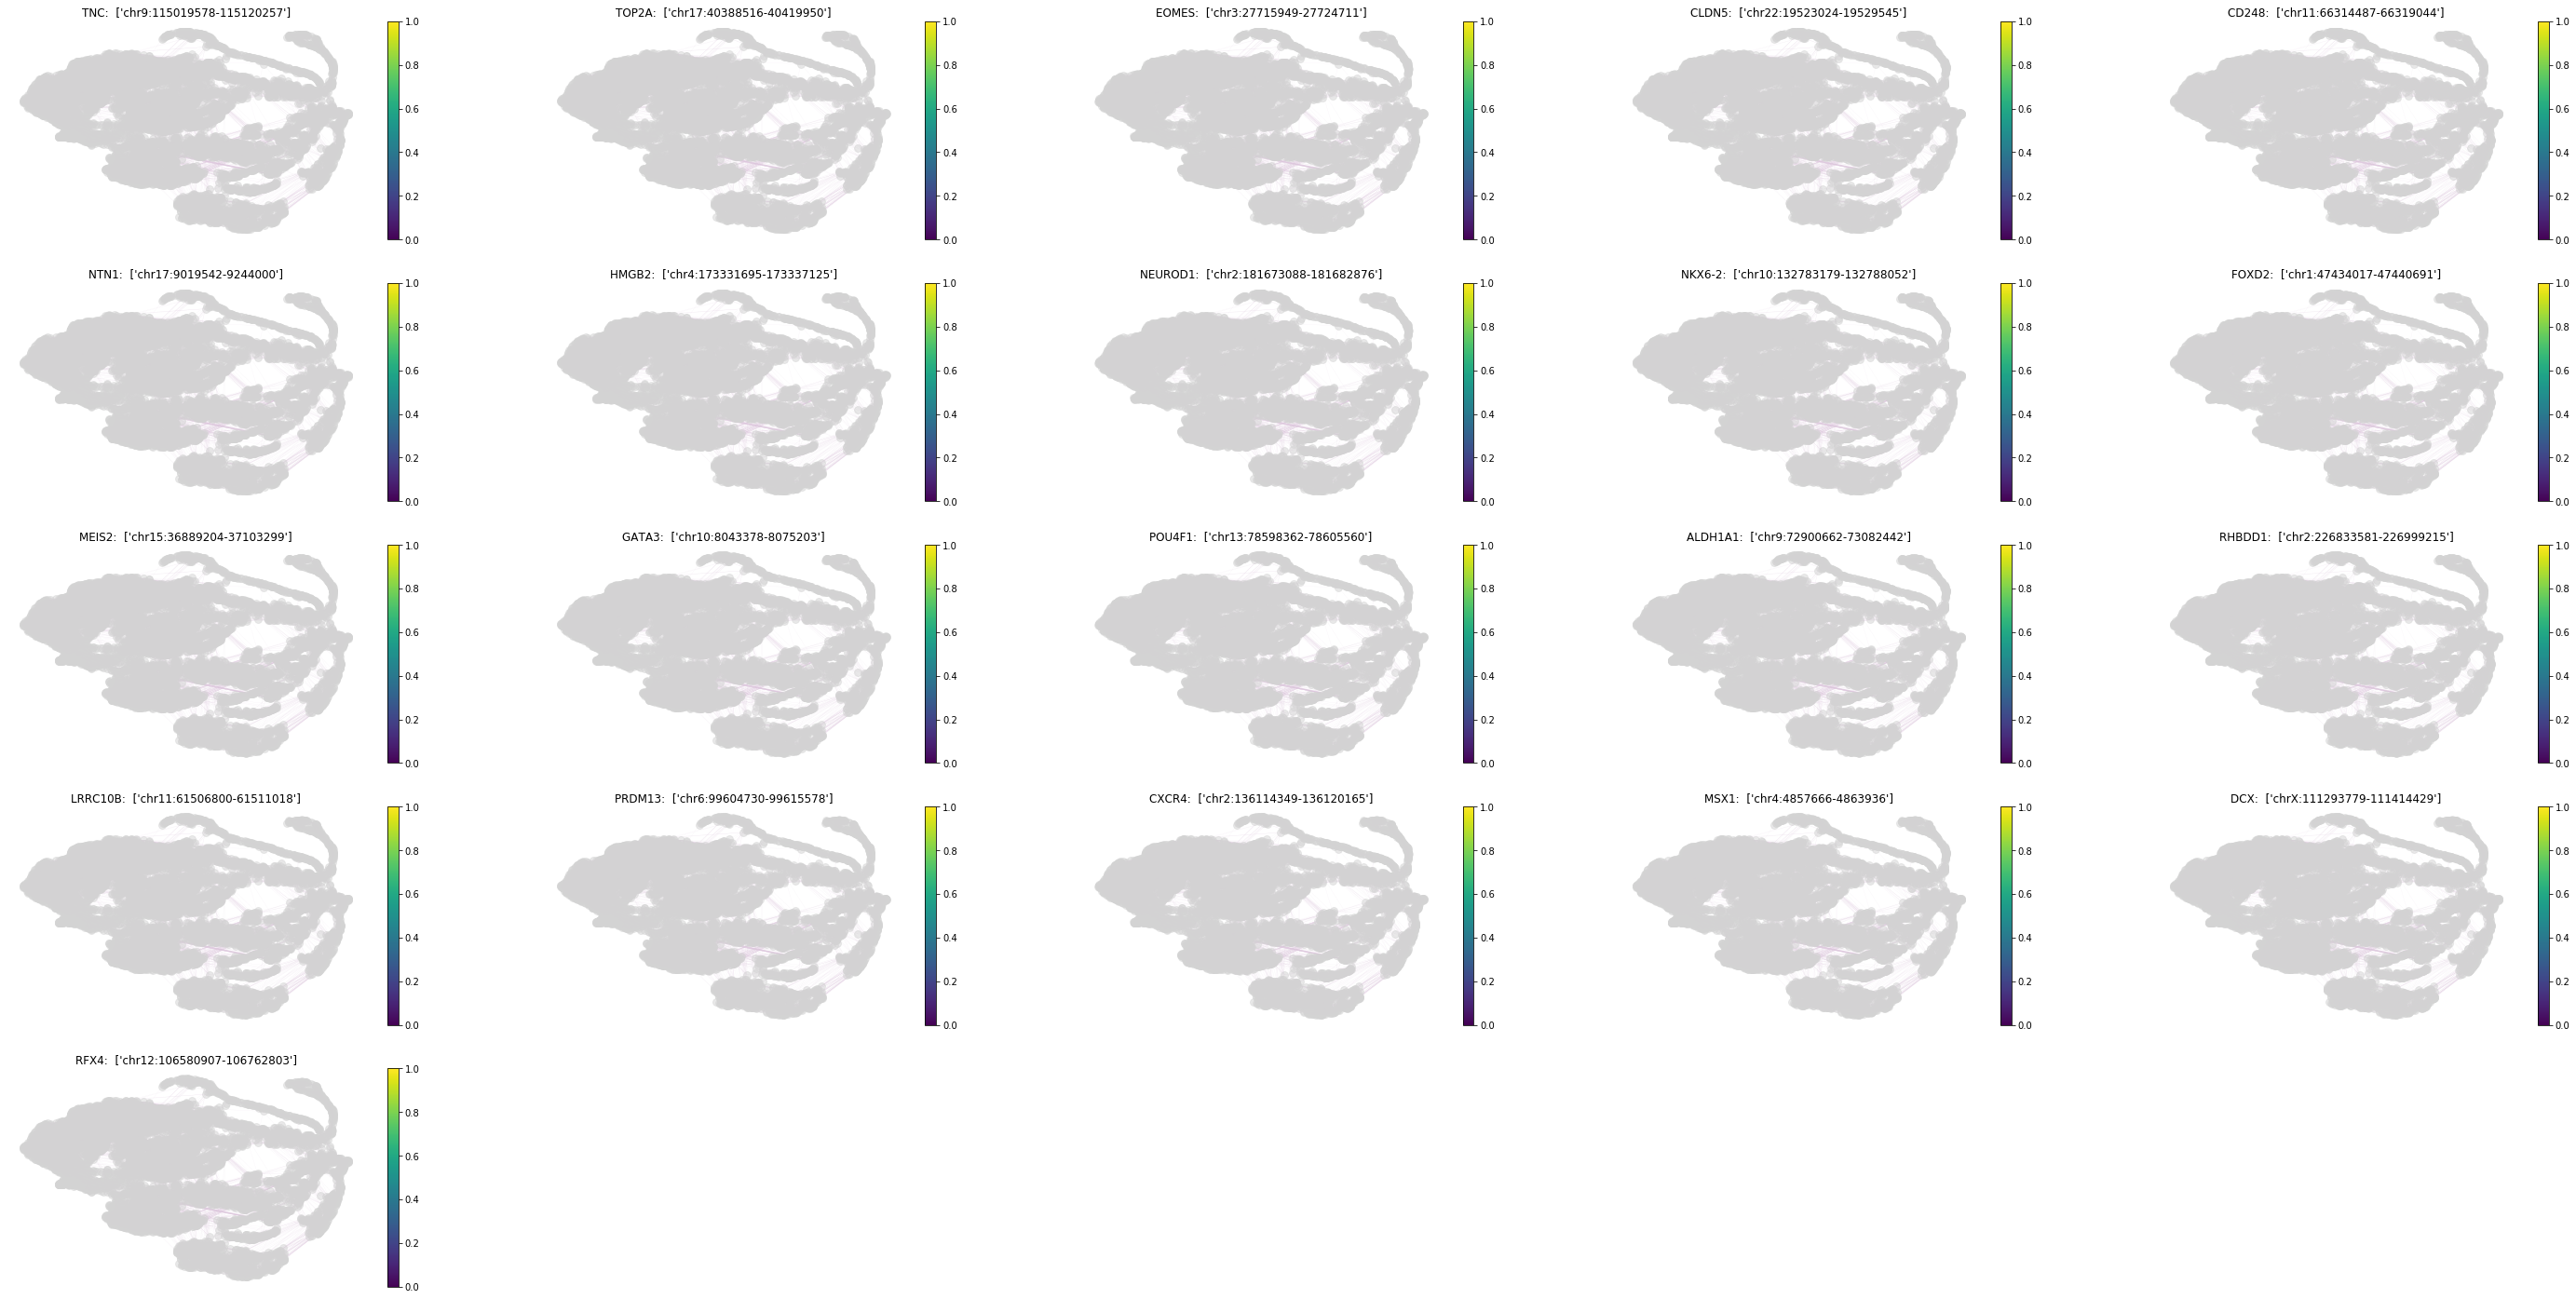

In [69]:
marker_plot(ds, '/data/proj/scATAC/chromograph/build_20200216/exported/marker_plot.png', markers = markers, lay= 'smooth', embedding = 'UMAP')

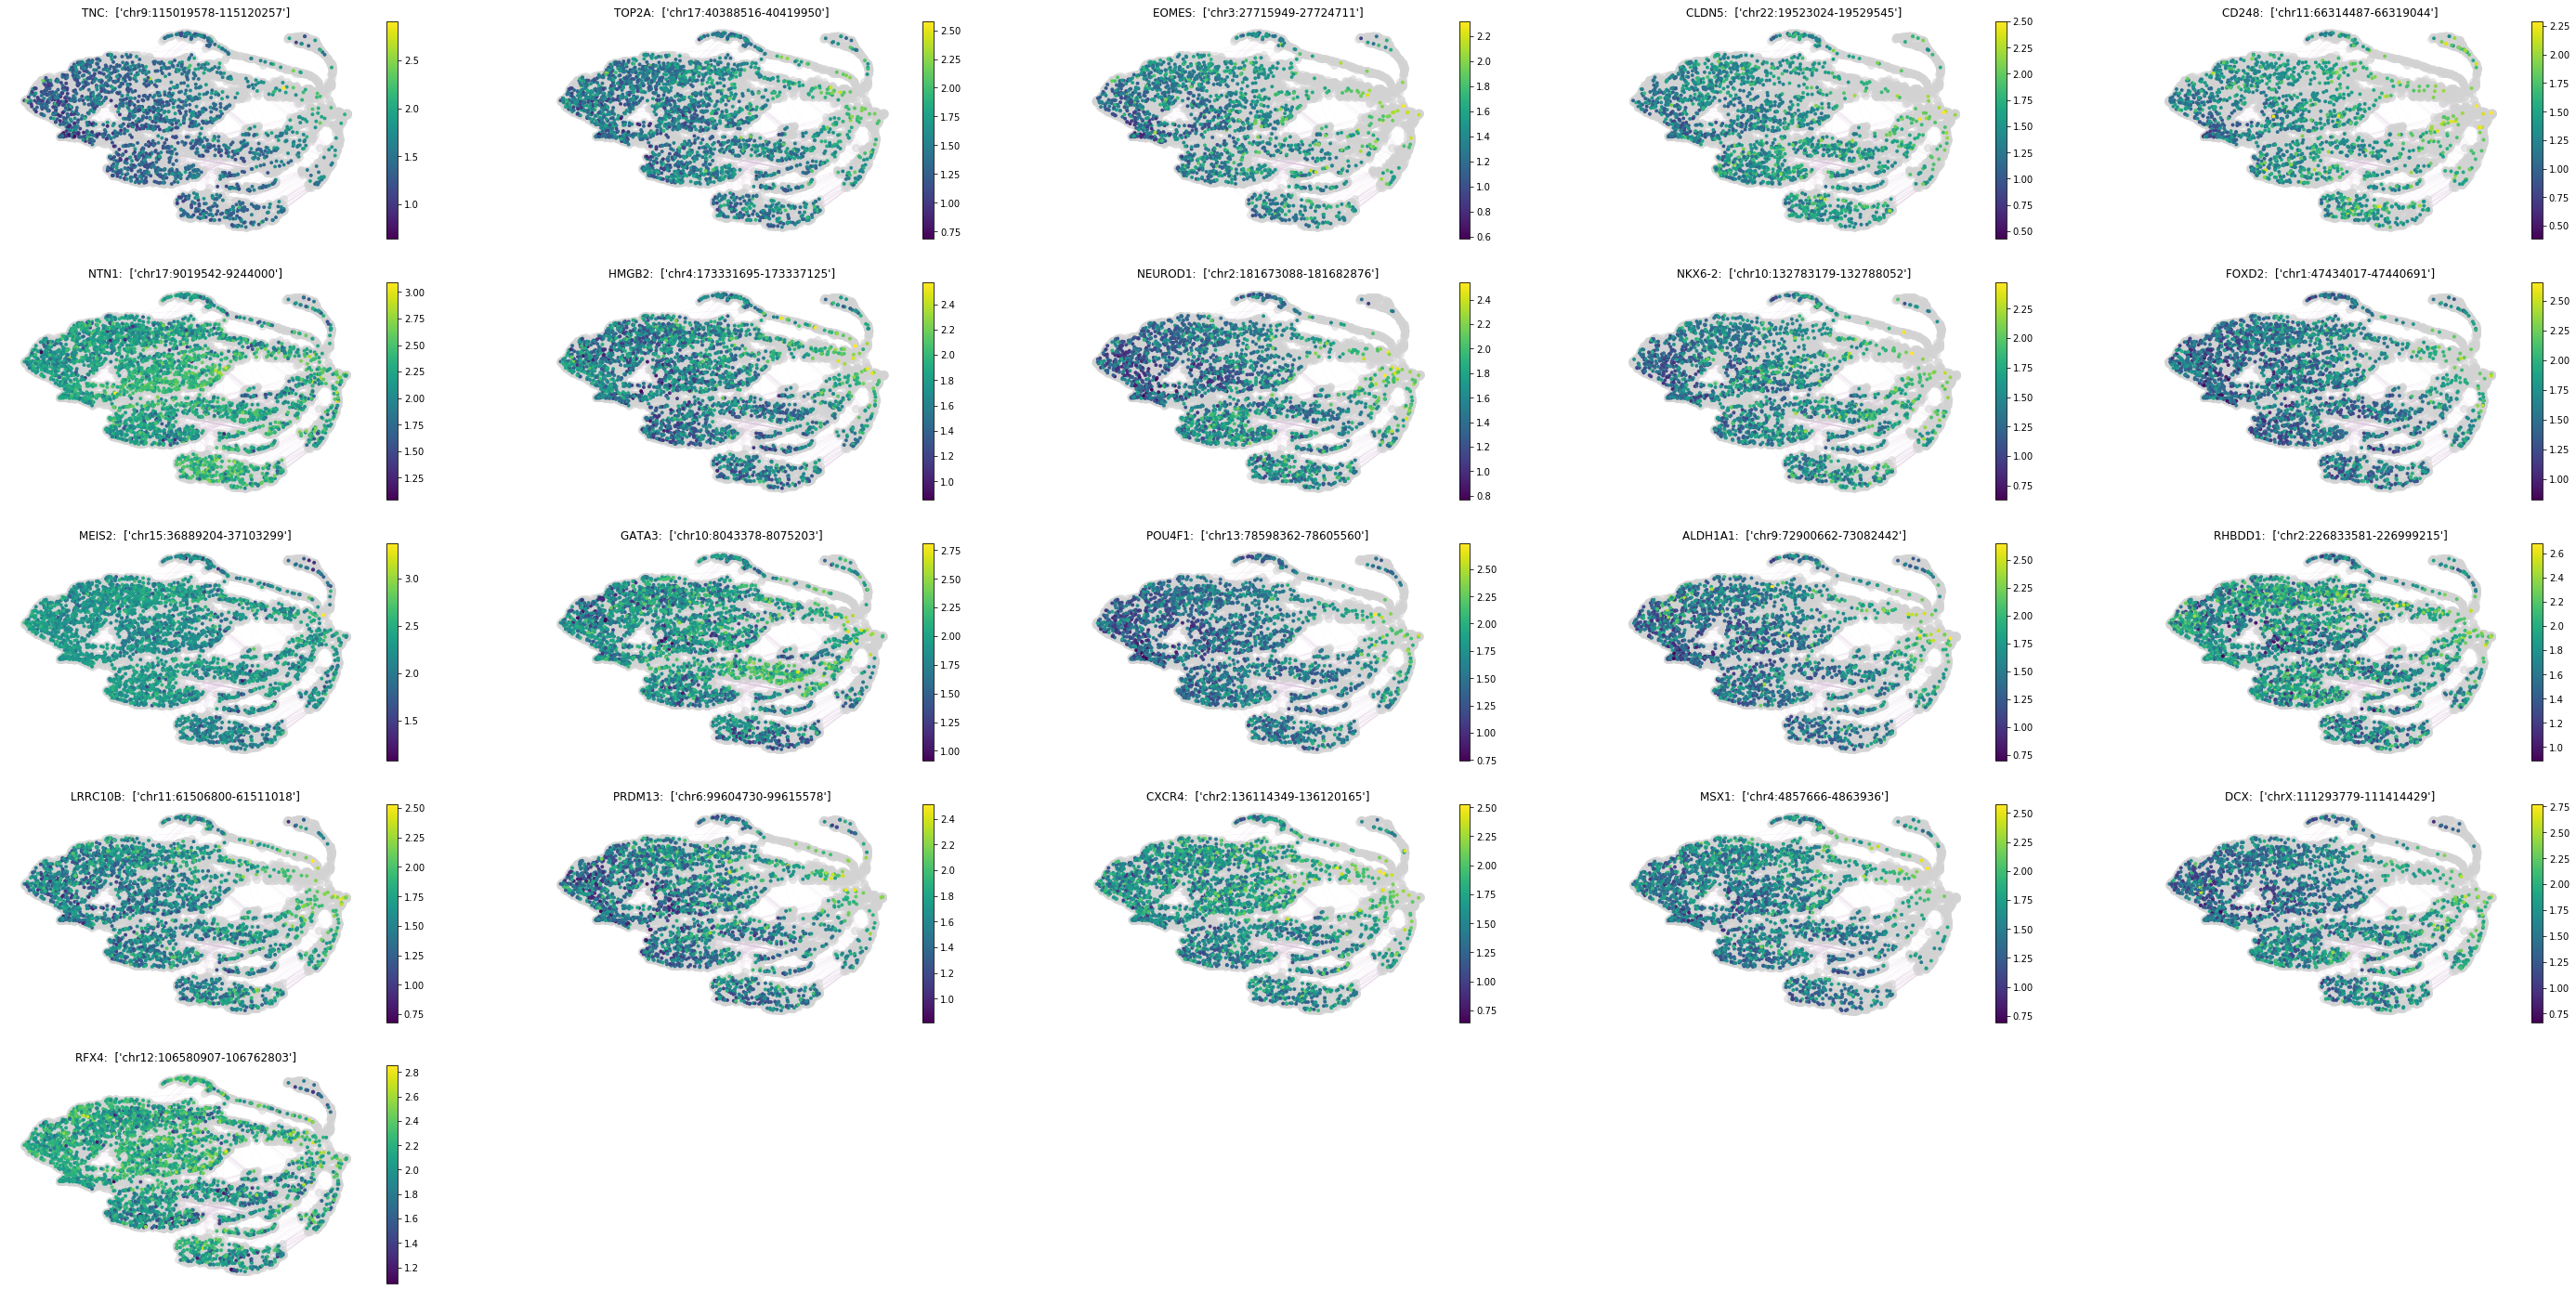

In [70]:
marker_plot(ds, '/data/proj/scATAC/chromograph/build_20200216/exported/marker_plot.png', markers = markers, lay= '', embedding = 'UMAP')